# GP-GAN for image blending
As described in paper: Gp-gan: Towards realistic high-resolution image blending

In [1]:
import os
COCO_API_DIR = 'D:/Datasets/COCO/cocoapi-master/PythonAPI'
COCO_ROOT = 'D:/Datasets/COCO/'
COCO_SET = 'train2017'
import sys
sys.path.append('../frontend')
sys.path.append('../backend')
sys.path.append(COCO_API_DIR)
import tensorflow as tf
from threading import Thread
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import glob
import time
from keras.layers import *
import keras
from keras.models import *
from IPython.display import clear_output
import keras.backend as K
import keras.optimizers
import datasets
import composition
from pycocotools.coco import COCO

c:\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


LEye is not present
REye is not present
LEar is not present
REar is not present
Nose is not present
Background is not present
HeadTop is not present
Neck is not present
Chest is not present
Pelvis is not present
Background is not present


Using TensorFlow backend.


In [11]:
# DISCRIMINATOR
vgg19 = keras.applications.vgg19.VGG19(
    include_top=False, 
    weights='imagenet', 
    input_tensor=None, 
    input_shape=(64,64,3), 
    pooling=None)

# DISCRIMINATOR MODEL
x = vgg19.output
x = Flatten()(x)
x = Dense(1, kernel_initializer='he_uniform')(x)
dis_model = Model(vgg19.input, x)


# GENERATOR
def encoder_decoder(x):
    # THIS IS BASICALLY THE ALEXNET ENCODER TAKEN FROM POOl5
    e64 = Conv2D(64, (4,4), strides=(2,2), name='e64', padding='same', activation='relu', kernel_initializer='he_uniform')(x)
    e128 = Conv2D(128, (4,4), strides=(2,2), name='e128', padding='same', activation='relu', kernel_initializer='he_uniform')(e64)
    e256 = Conv2D(256, (4,4), strides=(2,2), name='e256', padding='same', activation='relu', kernel_initializer='he_uniform')(e128)
    e512 = Conv2D(512, (4,4), strides=(2,2), name='e512', padding='same', activation='relu', kernel_initializer='he_uniform')(e256)

    # Bottleneck layers
    x = Flatten()(e512)
    x = Dense(4000, activation='relu', kernel_initializer='he_uniform')(x)
    x = Reshape((1,1,4000))(x)

    d512 = Conv2DTranspose(512, padding='valid', kernel_size=(4,4), name='d512', strides=(1,1), activation='relu', kernel_initializer='he_uniform')(x)
    r512 = keras.layers.add([ e512, d512  ], name='r512')
 
    d256 = Conv2D(256, (4,4), strides=(1,1), padding='same', name='d256',activation='relu', kernel_initializer='he_uniform')( UpSampling2D((2,2))(r512) ) 
#    d256 = Conv2DTranspose(256, padding='same', kernel_size=(4,4), name='d256', strides=(2,2), activation='relu', kernel_initializer='he_uniform')(r512)
    r256 = keras.layers.add([ e256, d256 ], name='r256')
    d128 = Conv2D(128, (4,4), strides=(1,1), padding='same', name='d128',activation='relu', kernel_initializer='he_uniform')( UpSampling2D((2,2))(r256) ) 
    r128 = keras.layers.add([ e128, d128 ], name='r128')
    d64 = Conv2D(64, (4,4), strides=(1,1), padding='same', name='d64',activation='relu', kernel_initializer='he_uniform')( UpSampling2D((2,2))(r128) ) 
    r64 = keras.layers.add([ e64,d64 ], name='r64')
    x = Conv2D(3, (4,4), strides=(1,1), padding='same', name='d32',activation='relu', kernel_initializer='he_uniform')( UpSampling2D((2,2))(r64) ) 
#    x = Conv2DTranspose(3, padding='same', kernel_size=(4,4), strides=(2,2), name='output', kernel_initializer='he_uniform')(r64)
    return x

# GENERATOR MODEL
x = Input((64,64,3)) 
xg = encoder_decoder(x)
gen_model = Model(x, xg)

gen_model.summary()

# GAN MODEL
gan_input = x 
gan_output = dis_model( xg )
print(xg)
gan_model = Model(gan_input, gan_output)

dis_model.load_weights('blending_gan_dis.ht')
gen_model.load_weights('blending_gan_gen.ht')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
e64 (Conv2D)                    (None, 32, 32, 64)   3136        input_4[0][0]                    
__________________________________________________________________________________________________
e128 (Conv2D)                   (None, 16, 16, 128)  131200      e64[0][0]                        
__________________________________________________________________________________________________
e256 (Conv2D)                   (None, 8, 8, 256)    524544      e128[0][0]                       
__________________________________________________________________________________________________
e512 (Conv

In [12]:
dis_model.trainable = False
gan_opt = keras.optimizers.RMSprop(lr=0.00001)
gan_model.compile(gan_opt, 'mean_absolute_error')

dis_model.trainable = True
dis_opt = keras.optimizers.RMSprop(lr=0.00001)
dis_model.compile(dis_opt, 'mean_absolute_error')

#gen_opt = keras.optimizers.Adam(lr=0.0002*0.999)
gen_opt = keras.optimizers.RMSprop(lr=0.00001)
gen_model.compile(gen_opt, 'mean_squared_error')

In [4]:
annFile='{}/annotations/instances_{}.json'.format(COCO_ROOT,COCO_SET)
annFileKPS = '{}/annotations/person_keypoints_{}.json'.format(COCO_ROOT,COCO_SET)
catNms = ['person']
coco=COCO(annFile)
coco_kps=COCO(annFileKPS)  
catIds = coco.getCatIds(catNms)
imgIds = coco.getImgIds(catIds=catIds )

loading annotations into memory...
Done (t=20.71s)
creating index...
index created!
loading annotations into memory...
Done (t=9.25s)
creating index...
index created!


In [5]:
def get_real_examples(list_out, coco, coco_kps, coco_root, imgIds, catIds, params, batch_size):
    print('Starting the real examples thread')
    # GET REFERENCE, NATURAL LOOKING EXAMPLES
    for i in range(0, batch_size):
        IM = composition.get_image_suitable_for_blending_with_meta(coco, coco_kps, coco_root, imgIds, catIds, longer_edge_size=params['longer_edge_size'], scale_range=params['scale_range_A'], shift_range=params['shift_range_A'], rot_range=params['rot_range_A'], allow_overlaps=params['allow_overlaps_in_A'])
        list_out.append(IM)
    print('Real examples done')

def get_fake_examples(list_out, coco, coco_kps, coco_root, imgIds, catIds, params, batch_size):
    print('Starting the fake examples thread')
    # GET GENERATED EXAMPLES
    for i in range(0, batch_size):
        while True:
            data_train = composition.get_composition(coco, coco_kps,coco_root, imgIds, catIds, params=params)
            if data_train is not None:
                list_out.append(data_train)
                break
    print('Fake examples done')
    

def get_training_examples(coco, coco_kps, coco_root, imgIds, catIds, composition_params, batch_size):
    
    list_real = list()
    list_fake = list()
    thread_real = Thread(target=get_real_examples, args=(list_real, coco, coco_kps, coco_root, imgIds, catIds, composition_params, batch_size))
    thread_fake = Thread(target=get_fake_examples, args=(list_fake, coco, coco_kps, coco_root, imgIds, catIds, composition_params, batch_size))
    
    thread_real.start()
    thread_fake.start()

    thread_real.join()
    thread_fake.join()
    return np.array(list_real), np.array(list_fake)

def trim_weights(model):
    for l in model.layers:
        w = l.get_weights()
        if len(w) > 0:
            print(w[0].shape)
            weights = np.clip(w[0], -0.01, 0.01)
            l.set_weights([ weights, w[1] ])


In [6]:

it = 0
progress = []

In [ ]:
composition_params = composition.default_composition_params
composition_params['longer_edge_size'] = 256
composition_params['allow_overlaps_in_A'] = True
composition_params['allow_overlaps_in_B'] = True
composition_params['max_occ_perc_th'] = 0.99
composition_params['overlap_perc_th'] = 0.99
batch_size = 32

while True:

    try:

        # Set up the threads to work in the background while running GPU tasks
        list_real = list()
        list_fake = list()
        thread_real = Thread(target=get_real_examples, args=(list_real, coco, coco_kps, COCO_ROOT, imgIds, catIds, composition_params, batch_size))
        thread_fake = Thread(target=get_fake_examples, args=(list_fake, coco, coco_kps, COCO_ROOT, imgIds, catIds, composition_params, batch_size))

        thread_real.start()
        thread_fake.start()

        if it > 0:
            if 0:
                plt.imshow( examples_real[0]['image_scaled_and_padded'].astype(np.uint8) )
                plt.show()
                plt.imshow( examples_real[0]['image_scaled_and_padded'].astype(np.uint8) )
                plt.show()

                plt.imshow( examples_fake[0]['image_scaled_and_padded'].astype(np.uint8) )
                plt.show()
                plt.imshow( examples_fake[0]['A']['rect_scaled_and_padded'].astype(np.uint8) )
                plt.show()
                plt.imshow( examples_fake[0]['inserted_mask'].astype(np.uint8) )
                plt.show()


            # CREATE BATCH FOR REAL VS FAKE FOR DISCRIMINATOR
            batch_real_x = np.zeros((batch_size//2, 64,64,3))
            batch_real_y = np.ones((batch_size//2, 1))
            batch_fake_x_in = np.zeros((batch_size//2, 64,64,3))
            batch_fake_y = np.zeros((batch_size//2, 1))
            for i in range(0, batch_size//2):
                batch_real_x[i] = cv2.resize( examples_real[i]['image_scaled_and_padded'], (64,64) )
                batch_fake_x_in[i] = cv2.resize( np.multiply(examples_fake[i]['image_scaled_and_padded'], np.expand_dims(examples_fake[i]['A']['rect_scaled_and_padded'],2)), (64,64) )
            batch_fake_x_out = gen_model.predict(batch_fake_x_in)
            dis_batch_x = np.concatenate([ batch_real_x,batch_fake_x_out ],0)
            dis_batch_y = np.concatenate([ batch_real_y,batch_fake_y ],0)


            dis_model.trainable = True
            dis_loss_cur = dis_model.train_on_batch(dis_batch_x, dis_batch_y)
            trim_weights(dis_model)
            print('Dis loss cur: {}'.format(dis_loss_cur))

            # CREATE BATCH FOR GENERATOR 
            batch_fake_x = np.zeros((batch_size, 64,64,3))
            for i in range(0, batch_size//2):
                batch_fake_x[i] = cv2.resize( np.multiply(examples_fake[i]['image_scaled_and_padded'], np.expand_dims(examples_fake[i]['A']['rect_scaled_and_padded'],2)), (64,64) )
            gen_loss_cur = gen_model.train_on_batch(batch_fake_x, batch_fake_x)
            print('Gen loss cur: {}'.format(gen_loss_cur))


            # GAN TRAINING IN FULL
            dis_model.trainable = False
            gan_loss_cur = gan_model.train_on_batch( batch_fake_x, np.ones((batch_size,1)) )
            print('GAN loss cur: {}'.format(gan_loss_cur))

            progress.append([ it, dis_loss_cur,  gen_loss_cur, gan_loss_cur ])

        # Wait for the threads to stop and store new training data
        thread_real.join()
        thread_fake.join()
        examples_real = np.array(list_real)
        examples_fake = np.array(list_fake)

        it += 1

        if it % 4 == 0:
            clear_output()
            print('It: {}, DIS loss: {}, GEN loss: {}, GAN loss: {}'.format(it, dis_loss_cur, gen_loss_cur, gan_loss_cur))

            plt.subplot(1,2,1)
            plt.imshow(batch_fake_x_in[0].astype(np.uint8))
            plt.title('Before')
            plt.subplot(1,2,2)
            plt.imshow(np.clip(batch_fake_x_out[0],0,255).astype(np.uint8))
            plt.title('After')
            plt.show()

            p = np.array(progress)
            p = p[np.max([0, p.shape[0]-100]):,]
            plt.figure()
            plt.semilogy( p[:,0], p[:,1] )
            plt.semilogy( p[:,0], p[:,2] )
            plt.semilogy( p[:,0], p[:,3] )
            plt.grid()
            plt.legend(['DIS loss','GEN loss', 'GAN loss'])
            plt.show()

        if it % 100 == 0:
            print('Saving models')
            dis_model.save_weights('blending_gan_dis.ht')
            gen_model.save_weights('blending_gan_gen.ht')
    except KeyboardInterrupt:
        print('Stopping on demand')
        break
    except:
        clear_output()
        print('Some exception')


(16, 64, 64, 3)


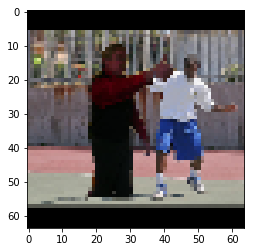

(16, 1)


In [8]:
print(batch_real_x.shape)

plt.imshow(batch_fake_x[0].astype(np.uint8))
plt.show()
print(batch_real_y.shape)